# Portfolio optimization

This example shows how to generate the QAOA with customized initial state and mixers for portfolio optimization

It contains the example of QAOA with Dicke state as the initial state and ring-XY mixer (https://arxiv.org/abs/2305.03857)

The portfolio problem formulation is as below
\begin{aligned}
\min_{\mathbf{x} \in \{0,1\}^N} f(\mathbf{x}) & = q \mathbf{x}^T \mathbf{W} \mathbf{x} - \boldsymbol{\mu}^T \mathbf{x}, \\
\mathop{\mathrm{s.t.}} \quad & \mathbf{1}^T \mathbf{x} = K    
\end{aligned}
N is the number of assets, $\boldsymbol{\mu}$ is a vector of expected returns, $\mathbf{W}$ is the covariance matrix between assets, q controls the trade-off between return and risk.
The constraint is the Hamming-weight constraint, where K denotes how many assets we can buy (equivalent to the budget constraint under the assumption of every asset being equally priced)

# Generate (scaled) portfolio optimization problem with Qiskit

In [1]:
import numpy as np
from qokit.portfolio_optimization import get_problem, get_problem_H

For weighted combinatorial optimization, a global scaling on the objective function is beneficial for the parameter optimziaiton. 
The scaling rule is from Eq. (8) of https://arxiv.org/abs/2305.15201

In [2]:
po_problem = get_problem(N=6,K=3,q=0.5,seed=1,pre=1)
means_in_spins = np.array([po_problem['means'][i] - po_problem['q'] * np.sum(po_problem['cov'][i, :]) for i in range(len(po_problem['means']))])
scale = 1 / (np.sqrt(np.mean((( po_problem['q']*po_problem['cov'])**2).flatten()))+np.sqrt(np.mean((means_in_spins**2).flatten())))

In [3]:
po_problem = get_problem(N=6,K=3,q=0.5,seed=1,pre=scale)

In [4]:
po_problem_H = get_problem_H(po_problem)

In [5]:
po_problem2 = get_problem(N=6,K=3,q=0.5,seed=1,pre='rule')

In [6]:
# confirm that the scaling rule in the function matches the one above
assert np.allclose(po_problem['cov'], po_problem2['cov'])
assert np.allclose(po_problem['means'], po_problem2['means'])

# Get QAOA objective and evaluation

In [7]:
from qokit.portfolio_optimization import portfolio_brute_force, get_sk_ini
from qokit.qaoa_objective_portfolio import get_qaoa_portfolio_objective

In [8]:
p = 1
qaoa_obj = get_qaoa_portfolio_objective(po_problem=po_problem,p=p,ini='dicke',mixer='trotter_ring',T=1,simulator='python')
best_portfolio = portfolio_brute_force(po_problem,return_bitstring=False)

In [9]:
x0 = get_sk_ini(p=p) 
# Alternative: random initial point# x0 = np.random.rand(2*p)

In [10]:
po_energy = qaoa_obj(x0).real
po_ar = (po_energy-best_portfolio[1])/(best_portfolio[0]-best_portfolio[1])
print(f"energy = {po_energy}, Approximation ratio = {po_ar}")

energy = 0.004962484517944696, Approximation ratio = 0.7564585339722991


# Optimize QAOA parameters

Note that we are using NLopt for optimization as it supports better-performing BOBYQA optimizer. Run `pip install nlopt` to install this dependency.

In [11]:
from scipy.optimize import minimize
import nlopt

In [12]:
def minimize_nlopt(f, x0, rhobeg=None, p=None):
    def nlopt_wrapper(x, grad):
        if grad.size > 0:
            sys.exit("Shouldn't be calling a gradient!")
        return f(x).real

    opt = nlopt.opt(nlopt.LN_BOBYQA, 2 * p)
    opt.set_min_objective(nlopt_wrapper)

    opt.set_xtol_rel(1e-8)
    opt.set_ftol_rel(1e-8)
    opt.set_initial_step(rhobeg)
    xstar = opt.optimize(x0)
    minf = opt.last_optimum_value()

    return xstar, minf

In [13]:
_, opt_energy = minimize_nlopt(qaoa_obj, x0, p=1, rhobeg=0.01/1)
opt_ar = (opt_energy-best_portfolio[1])/(best_portfolio[0]-best_portfolio[1])
print(f"energy = {opt_energy}, Approximation ratio = {opt_ar}")

energy = 0.004135567715736566, Approximation ratio = 0.8050399835268952


In [14]:
res = minimize(qaoa_obj, x0, method='COBYLA', options={'rhobeg':0.001})
print(f"energy = {res.fun}, Approximation ratio = {(res.fun-best_portfolio[1])/(best_portfolio[0]-best_portfolio[1])}")

energy = 0.0041355677841988115, Approximation ratio = 0.8050399795047312


# Get qiskit circuit

In [15]:
from qokit.qaoa_circuit_portfolio import get_qaoa_circuit, get_parameterized_qaoa_circuit

In [16]:
qc = get_qaoa_circuit(po_problem, gammas=x0[:p]/2, betas=x0[p:]/2, depth=p)

# Verify the qiskit circuit

It is important to verify the qiskit circuit simulation with fur-backend simulations for hardware experiments. For portfolio optimization, there is a 1/2 scaling of (gamma, beta) in the qiskit circuit. 
Also see: `tests/test_portfolio_optimization/test_portfolio_qokitandqiskit`

In [17]:
from qiskit import execute, Aer
from qokit.utils import reverse_array_index_bit_order
from qokit.qaoa_circuit_portfolio import get_energy_expectation_sv

In [18]:
backend = Aer.get_backend("statevector_simulator")
qc = get_qaoa_circuit(po_problem, gammas=x0[:p]/2, betas=x0[p:]/2, depth=p)
result = execute(qc, backend).result()
sv1 = reverse_array_index_bit_order(result.get_statevector())

In [19]:
parameterized_qc = get_parameterized_qaoa_circuit(po_problem, depth=p)
qc2 = parameterized_qc.bind_parameters(np.hstack([x0[p:]/2, x0[:p]/2]))
result = execute(qc2, backend).result()
sv2 = reverse_array_index_bit_order(result.get_statevector())
assert np.allclose(sv1, sv2)

In [20]:
qaoa_obj_qiskit = get_qaoa_portfolio_objective(po_problem=po_problem, p=p, simulator="qiskit", ini="dicke", mixer="trotter_ring", T=1)
qaoa_obj_auto = get_qaoa_portfolio_objective(po_problem=po_problem, p=p, simulator="auto", ini="dicke", mixer="trotter_ring", T=1)
assert np.allclose(qaoa_obj_auto(x0), qaoa_obj_qiskit(x0))
assert np.allclose(get_energy_expectation_sv(po_problem,sv1), qaoa_obj_qiskit(x0))

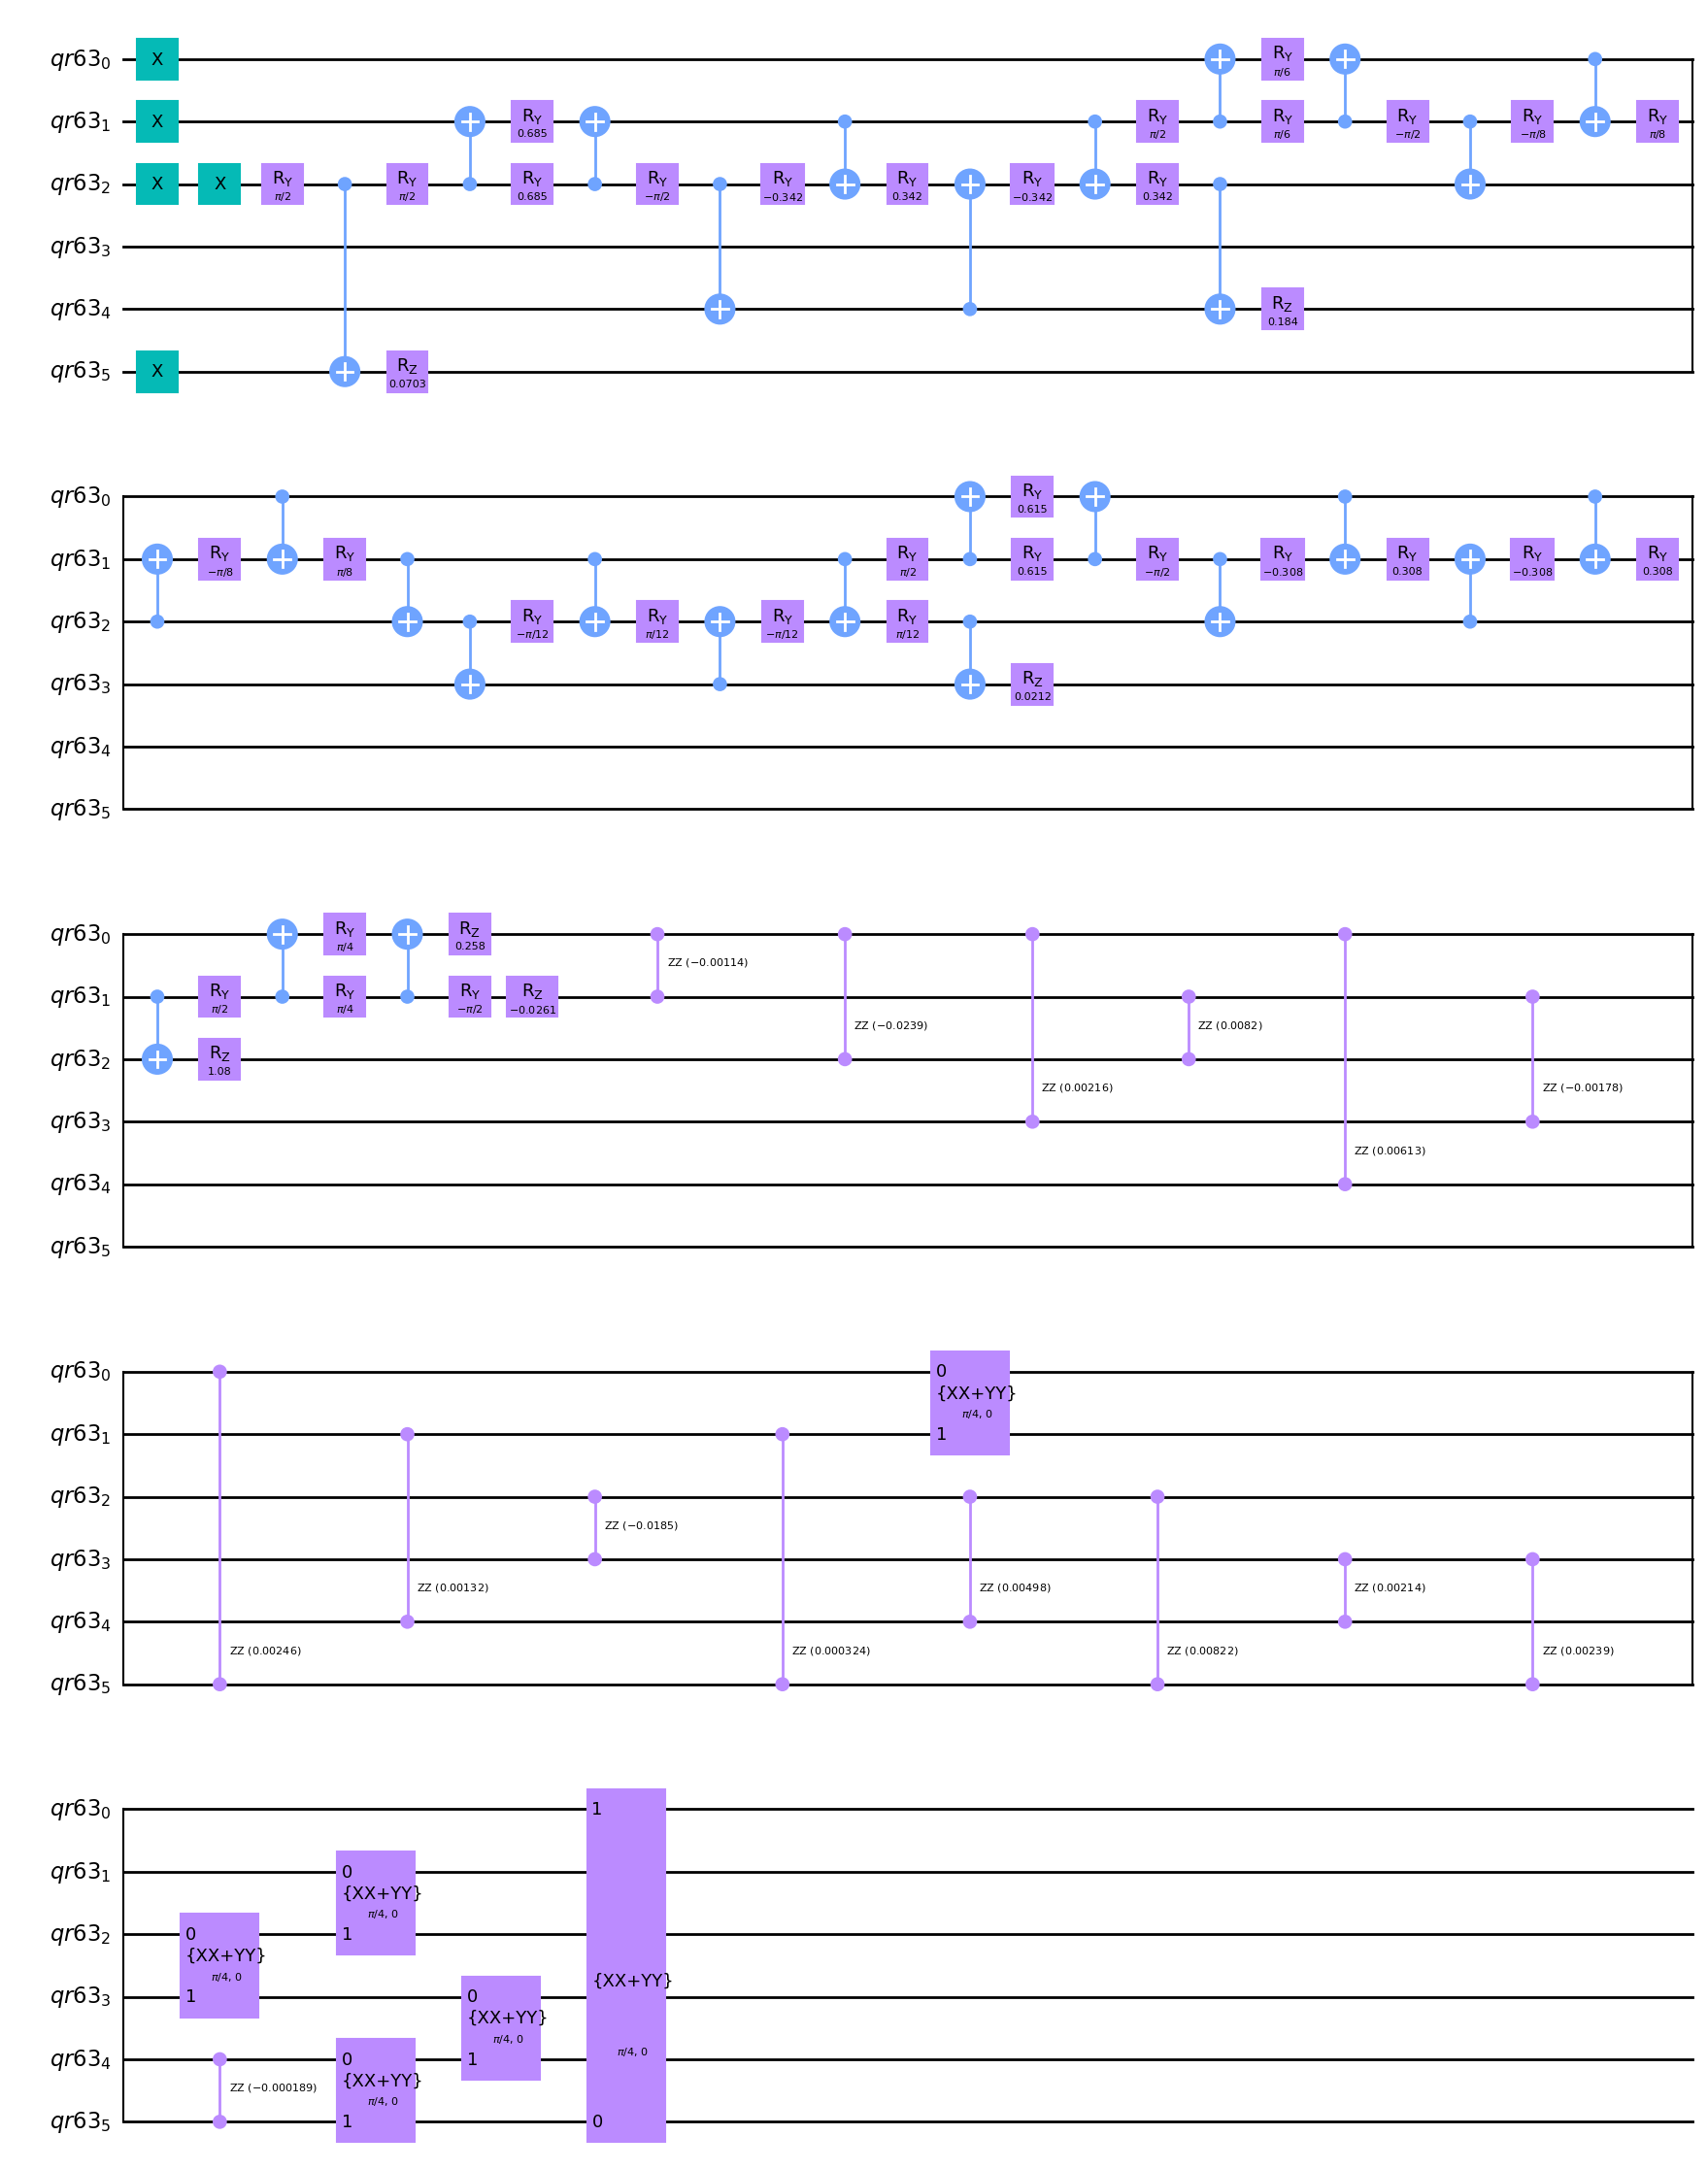

In [21]:
qc.draw("mpl")